# SIR Epidemiological Model

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp
import datetime

## Basic SIRD

In [2]:
population = pd.read_csv("data/us/demographics/county_populations.csv")
nyt_data = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")

In [85]:
population.head(1)

,FIPS,total_pop,60plus
0,1001,55036,10523


In [86]:
nyt_data.head(1)

,fips,date,county,state,cases,deaths
0,53061,2020-01-21,Snohomish,Washington,1.0,0.0


In [196]:
fips = 6037
pop = int(population.loc[population["FIPS"] == fips]["total_pop"])
df = nyt_data.loc[nyt_data["fips"] == fips]
df.reset_index(inplace=True)

In [197]:
# Find first cases
infection_start = df.loc[df["cases"] > 0].first_valid_index()
start_date = df.iloc[infection_start]["date"]

In [198]:
# Initial number of susceptible, infectious, recovered, deceased
inf_init = df.iloc[infection_start]["cases"]
rec_init = 0
dec_init = df.iloc[infection_start]["deaths"]
sus_init = pop - inf_init - rec_init - dec_init

In [231]:
beta = 0.19 # Infection rate
gamma = 1./14 # Recovery rate
mu = 1./60 # Mortality rate

In [232]:
t = np.linspace(0, len(df), len(df))

In [9]:
def get_derivatives(y, t, N, beta, gamma, mu):
    S, I, R, D = y
    dSdt = - beta * I * S / N
    dIdt = beta * I * S / N - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dIdt, dRdt, dDdt

In [234]:
y_init = sus_init, inf_init, rec_init, dec_init

In [235]:
# Integrate over the time space
res = odeint(get_derivatives, y_init, t, args=(pop, beta, gamma, mu))

In [236]:
S, I, R, D = res.T

In [237]:
# Combine predictions and data to plot
df["S"], df["I"], df["R"], df["D"], df["c_deaths"], df["c_cases"], df["C"] = 0, 0, 0, 0, 0, 0, 0
for i, row in df.iterrows():
    df.loc[i, "S"] = S[i]
    df.loc[i, "I"] = I[i]
    df.loc[i, "R"] = R[i]
    df.loc[i, "D"] = D[i]
    
    try:
        df.at[i, "C"] = df.loc[i, "I"] + df.loc[i, "R"]
        df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
    except Exception as e:
        df.at[i, "C"] = df.loc[i, "I"] + df.loc[i, "R"]
        df.at[i, "c_deaths"] = df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i, "cases"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Second argument 'C' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Second argument 'D' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  import sys


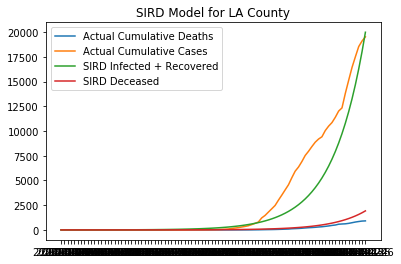

In [238]:
# Plot the results vs. the actual data
fig, ax = plt.subplots()
ax.plot('date', 'c_deaths', data=df, label="Actual Cumulative Deaths")
ax.plot('date', 'c_cases', data=df, label="Actual Cumulative Cases")
#ax.plot('date', 'S', data=df, label="SIRD Susceptible")
ax.plot('date', 'C', data=df, label="SIRD Infected + Recovered")
ax.plot('date', 'D', data=df, label="SIRD Deceased")
plt.title("SIRD Model for LA County")
plt.legend()
plt.show()

## Finding Better Parameters with HyperOpt

In [261]:
def SIRD_rmse(S, I, R, D, df):
    case_err, death_err, c_case_err, c_death_err = 0, 0, 0, 0
    for i, row in df.iterrows():
        if i == 0:
            this_cases = I[i] + R[i]
            this_deaths = D[i]
        else:
            this_cases = I[i] - I[i-1] + R[i] - R[i-1]
            this_deaths = D[i] - D[i-1]
            
        case_err += (row["cases"] - this_cases) ** 2
        death_err += (row["deaths"] - this_deaths) ** 2
        c_case_err += (row["c_cases"] - I[i]- R[i]) ** 2
        c_death_err += (row["c_deaths"] - D[i]) ** 2
    
    case_err /= len(S)
    death_err /= len(S)
    
    return math.sqrt(death_err)# + math.sqrt(c_death_err) / 2

In [231]:
class HyperOpt(object):
    def __init__(self, population, data, y_init, timespace):
        self.data = data.copy()
        self.data.reset_index(inplace=True)
        self.y_init = y_init
        self.pop = population
        self.t = timespace
    
    def eval_sird(self, params):
        result = odeint(get_derivatives, self.y_init, self.t, args=(self.pop, params["beta"], params["gamma"], params["mu"]))
        S, I, R, D = result.T
        rmse = SIRD_rmse(S, I, R, D, self.data)
        return rmse
    
    def optimize_params(self, space, trials, algo, max_evals):
        result = fmin(fn=self.eval_sird, space=space, algo=algo, max_evals=max_evals, trials=trials, verbose=False)
        return result, trials

In [232]:
fips = 17031
pop = int(population.loc[population["FIPS"] == fips]["total_pop"])
df = nyt_data.loc[nyt_data["fips"] == fips]
df.reset_index(inplace=True)
df["c_deaths"], df["c_cases"] = 0, 0
for i, row in df.iterrows():   
    try:
        df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
    except Exception as e:
        df.at[i, "c_deaths"] = df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i, "cases"]

# Find first cases
infection_start = df.loc[df["cases"] > 0].first_valid_index()
start_date = df.iloc[infection_start]["date"]

# Initial number of susceptible, infectious, recovered, deceased
inf_init = df.iloc[infection_start]["cases"]
rec_init = 0
dec_init = df.iloc[infection_start]["deaths"]
sus_init = pop - inf_init - rec_init - dec_init
y_init = sus_init, inf_init, rec_init, dec_init

t = np.linspace(0, len(df)-14-infection_start, len(df)-14-infection_start)

print (len(t))

80


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [233]:
param_space = {
    "beta": hp.uniform("beta", 0.1, 0.3),
    "gamma": hp.uniform("gamma", 0.05, 0.1),
    "mu": hp.uniform("mu", 0.02, 0.03)
}

In [234]:
hopt = HyperOpt(pop, df[infection_start:-14], y_init, t)

In [235]:
optimized, trials = hopt.optimize_params(space=param_space, trials=Trials(), algo=tpe.suggest, max_evals=100)
print("Best parameters:\n", optimized)

Best parameters:
 {'beta': 0.16981106638090634, 'gamma': 0.051709218606616605, 'mu': 0.025787173135665427}


In [1]:
# Plot the results
max_deaths = nyt_data["deaths"][:-14].max()

t = np.linspace(0, len(df), len(df))
res = odeint(get_derivatives, y_init, t, args=(pop, optimized["beta"], optimized["gamma"], optimized["mu"]))
S, I, R, D = res.T

df["S"], df["I"], df["R"], df["D"], df["D_diff"], df["c_deaths"], df["c_cases"], df["C"] = 0, 0, 0, 0, 0, 0, 0, 0
for i, row in df.iterrows():
    if i < infection_start:
        df.loc[i, "S"] = 0
        df.loc[i, "I"] = 0
        df.loc[i, "R"] = 0
        df.loc[i, "D"] = 0
        df.loc[i, "D_diff"] = 0
    else:
        df.loc[i, "S"] = S[i-infection_start]
        df.loc[i, "I"] = I[i-infection_start]
        df.loc[i, "R"] = R[i-infection_start]
        df.loc[i, "D"] = D[i-infection_start]
        if i == infection_start:
            df.loc[i, "D_diff"] = D[i-infection_start]
        else:
            df.loc[i, "D_diff"] = D[i-infection_start] - D[i-1-infection_start]
    
    try:
        df.at[i, "C"] = df.loc[i, "I"] + df.loc[i, "R"]
        df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
    except Exception as e:
        df.at[i, "C"] = df.loc[i, "I"] + df.loc[i, "R"]
        df.at[i, "c_deaths"] = df.loc[i, "deaths"]
        df.at[i, "c_cases"] = df.loc[i, "cases"]

df["D_diff"].clip(lower=0, upper=max_deaths, inplace=True)
        
fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=df[:-14], label='Actual Deaths per Day (Training)')
ax.plot('date', 'deaths', data=df[-14:], label='Actual Deaths per Day (Testing)')
ax.plot('date', 'D_diff', data=df, label='SIRD Deceased w/ Differencing')
#ax.plot('date', 'c_deaths', data=df, label="Actual Cumulative Deaths")
#ax.plot('date', 'c_cases', data=df, label="Actual Cumulative Cases")
#ax.plot('date', 'S', data=df, label="SIRD Susceptible")
#ax.plot('date', 'C', data=df, label="SIRD Infected + Recovered")
#ax.plot('date', 'D', data=df, label="SIRD Deceased")
plt.title("SIRD Model vs. Actual Data")
plt.legend()
plt.show()

NameError: name 'pop' is not defined

# Generating a Submission with SIRD

In [262]:
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")

In [263]:
test_per = 14
pred_per = 0

In [264]:
ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = [], [], [], [], [], [], [], [], [], []
z_80 = 1.28
z_60 = 0.84
z_40 = 0.525
z_20 = 0.25

In [299]:
print(str(datetime.datetime.now())+"\n")

max_deaths = 750

for idx, row in fips_list.iterrows():
    county = int(row["FIPS"])
    print("County " + str(county) + "...", end='\r', flush=True)
        
    df = nyt_data.loc[nyt_data["fips"] == county][:-test_per]
    df.reset_index(inplace=True)
    df["c_deaths"], df["c_cases"] = 0, 0
    for i, row in df.iterrows():   
        try:
            df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
            df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
        except Exception as e:
            df.at[i, "c_deaths"] = df.loc[i, "deaths"]
            df.at[i, "c_cases"] = df.loc[i, "cases"]
    
    try: 
        cum_deaths = df.iloc[-1]["c_deaths"]
    except IndexError as e:
        if len(df) == 0:
            #print("No data found for county", str(county), ":", row["COUNTY"])
            continue
        else:
            cum_deaths = 0
        
    if cum_deaths >= 15:
        try:
            pop = int(population.loc[population["FIPS"] == county]["total_pop"])
        except TypeError as e:
            print("No population found for county", str(county), ":", row["COUNTY"])
            print("This county has at least 15 cumulative deaths!")
            raise e
            
        # Find first cases
        infection_start = df.loc[df["cases"] > 0].first_valid_index()
        start_date = df.iloc[infection_start]["date"]

        # Initial number of susceptible, infectious, recovered, deceased
        inf_init = df.iloc[infection_start]["cases"]
        rec_init = 0
        dec_init = df.iloc[infection_start]["deaths"]
        sus_init = pop - inf_init - rec_init - dec_init
        y_init = sus_init, inf_init, rec_init, dec_init

        t = np.linspace(0, len(df)-infection_start, len(df)-infection_start)

        param_space = {
            "beta": hp.uniform("beta", 0, 1),
            "gamma": hp.uniform("gamma", 0, 1),
            "mu": hp.uniform("mu", 0, 1)
        }

        hopt = HyperOpt(pop, df[infection_start:], y_init, t)
        optimized, trials = hopt.optimize_params(space=param_space, trials=Trials(), algo=tpe.suggest, max_evals=100)

        t = np.linspace(0, len(df) + test_per + pred_per, len(df) + test_per + pred_per)
        res = odeint(get_derivatives, y_init, t, args=(pop, optimized["beta"], optimized["gamma"], optimized["mu"]))
        S, I, R, D = res.T

        date = datetime.date.fromisoformat(df.iloc[0]["date"]) + datetime.timedelta(days=int(infection_start))
        for i, ddata in enumerate(D):
            this_id = date.isoformat() + "-" + str(county)
            date += datetime.timedelta(days=1)

            if i == 0:
                mid = ddata
            else:
                mid = ddata - D[i - 1]
                
            if mid > max_deaths: mid = max_deaths
            
            sd = 3 * math.sqrt(mid)

            ids.append(this_id)
            i10.append(mid - sd * z_80)
            i20.append(mid - sd * z_60)
            i30.append(mid - sd * z_40)
            i40.append(mid - sd * z_20)
            i50.append(mid)
            i60.append(mid + sd * z_20)
            i70.append(mid + sd * z_40)
            i80.append(mid + sd * z_60)
            i90.append(mid + sd * z_80)
    
    else:
        date = datetime.date.fromisoformat(df.iloc[0]["date"])
        for i in range(len(df) + test_per + pred_per):
            this_id = date.isoformat() + "-" + str(county)
            date += datetime.timedelta(days=1)
            
            ids.append(this_id)
            i10.append(0)
            i20.append(0)
            i30.append(0)
            i40.append(0)
            i50.append(0)
            i60.append(0)
            i70.append(0)
            i80.append(0)
            i90.append(0)

print("\n" + str(datetime.datetime.now()))


2020-05-05 19:42:41.208393

County 78030...
2020-05-05 19:47:18.556757


In [300]:
predictions = pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90})

In [301]:
predictions["10"] = predictions["10"].apply(lambda x: x if x >= 1 else 0)
predictions["20"] = predictions["20"].apply(lambda x: x if x >= 1 else 0)
predictions["30"] = predictions["30"].apply(lambda x: x if x >= 1 else 0)
predictions["40"] = predictions["40"].apply(lambda x: x if x >= 1 else 0)
predictions["50"] = predictions["50"].apply(lambda x: x if x >= 1 else 0)
predictions["60"] = predictions["60"].apply(lambda x: x if x >= 1 else 0)
predictions["70"] = predictions["70"].apply(lambda x: x if x >= 1 else 0)
predictions["80"] = predictions["80"].apply(lambda x: x if x >= 1 else 0)
predictions["90"] = predictions["90"].apply(lambda x: x if x >= 1 else 0)

In [302]:
predictions.to_csv("test_submissions/sird.csv", index=False)

Best loss: 0.7628444761093374

## Which Counties are a Good Fit for SIRD?

In [332]:
total_deaths = fips_list.copy()
total_deaths.drop(["MSA/PMSA NECMA", "ST", "COUNTY"], axis=1, inplace=True)
total_deaths["deaths"] = 0
total_deaths.head()

,FIPS,deaths
0,1001,0
1,1003,0
2,1005,0
3,1007,0
4,1009,0


In [333]:
for i, row in total_deaths.iterrows():
    county = int(row["FIPS"])
    c_row = nyt_data.loc[nyt_data["fips"] == county]
    cum_deaths = 0
    for a, item in c_row.iterrows(): cum_deaths += int(item["deaths"])
    
    total_deaths.at[i, "deaths"] = cum_deaths

total_deaths.head()

,FIPS,deaths
0,1001,3
1,1003,3
2,1005,0
3,1007,0
4,1009,0


In [334]:
total_deaths.dropna(inplace=True)

In [335]:
total_deaths.sort_values("deaths", inplace=True, ascending=False)
total_deaths.head()

,FIPS,deaths
1875,36061,12648
1874,36059,2152
1326,26163,1580
619,17031,1313
1896,36103,1265


In [339]:
test_per = 14
total_deaths.reset_index(inplace=True)

for i, row in total_deaths.iterrows():
    if i > 20: break
    fips = row["FIPS"]
        
    pop = int(population.loc[population["FIPS"] == fips]["total_pop"])
    df = nyt_data.loc[nyt_data["fips"] == fips]
    df.reset_index(inplace=True)
    df["c_deaths"], df["c_cases"] = 0, 0
    for i, row in df.iterrows():   
        try:
            df.at[i, "c_deaths"] = df.loc[i - 1, "c_deaths"] + df.loc[i, "deaths"]
            df.at[i, "c_cases"] = df.loc[i - 1, "c_cases"] + df.loc[i, "cases"]
        except Exception as e:
            df.at[i, "c_deaths"] = df.loc[i, "deaths"]
            df.at[i, "c_cases"] = df.loc[i, "cases"]

    # Find first cases
    infection_start = df.loc[df["cases"] > 0].first_valid_index()
    start_date = df.iloc[infection_start]["date"]

    # Initial number of susceptible, infectious, recovered, deceased
    inf_init = df.iloc[infection_start]["cases"]
    rec_init = 0
    dec_init = df.iloc[infection_start]["deaths"]
    sus_init = pop - inf_init - rec_init - dec_init
    y_init = sus_init, inf_init, rec_init, dec_init

    t = np.linspace(0, len(df)-test_per-infection_start, len(df)-test_per-infection_start)
    
    param_space = {
        "beta": hp.uniform("beta", 0, 1),
        "gamma": hp.uniform("gamma", 0, 1),
        "mu": hp.uniform("mu", 0, 1)
    }

    hopt = HyperOpt(pop, df[infection_start:-test_per], y_init, t)
    optimized, trials = hopt.optimize_params(space=param_space, trials=Trials(), algo=tpe.suggest, max_evals=100)
    
    t = np.linspace(0, len(df), len(df))
    res = odeint(get_derivatives, y_init, t, args=(pop, optimized["beta"], optimized["gamma"], optimized["mu"]))
    S, I, R, D = res.T
    
    rmse = SIRD_rmse(S, I, R, D, df)
    
    print("Error for county", fips, "was", str(rmse))
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Error for county 36061 was 1158.027080969778
Error for county 36059 was 264.0351977973268
Error for county 26163 was 120.35064960014144
Error for county 17031 was 26.24822374568576
Error for county 36103 was 487.81010376207104
Error for county 36119 was 25.358076346747737
Error for county 34013 was 81.96195440368486
Error for county 34003 was 79.74670352718593
Error for county 6037 was 12.940415688622076
Error for county 9001 was 14.636666592611544
Error for county 25017 was 7.026208432028948
Error for county 34017 was 32.875378287169255
Error for county 26125 was 27.38991588294568
Error for county 9003 was 11.861866292115419
Error for county 34039 was 25.098935408288266
Error for county 26099 was 30.872217570726082
Error for county 42101 was 18.156172434176593
Error for county 34023 was 20.490366032227747
Error for county 9009 was 19.97221689887727
Error for county 34031 was 12.29155645187035
Error for county 25025 was 4.070874312434727


Counties with error under 100:
- 17031
- 36119
- 34013
- 34003
- 6037
- 9001
- 25017
- 34017
- 26125
- 9003
- 34039
- 26099
- 42101
- 34023
- 9009
- 34031
- 25025

Counties with error under 25:
- 6037
- 9001
- 25017
- 9003
- 42101
- 34023
- 9009
- 34031
- 25025